In [1]:
import warnings
warnings.filterwarnings('ignore', 'numpy.dtype size changed')
warnings.filterwarnings( 'ignore', category=FutureWarning)

from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import metpy.calc as mpcalc
import metpy.constants as mpconstants
from metpy.units import units
import numpy as np
from pyproj import Proj
from scipy.ndimage import gaussian_filter
import xarray as xr

In [2]:
def isobaric_PV(potential_temperature, pressure, u, v, dx, dy, lats,
                                   axis=0, dim_order='yx'):
    from metpy.constants import g
    if np.shape(potential_temperature)[axis] < 3:
        raise ValueError('Length of potential temperature along axis '
                         '{} must be at least 3.'.format(axis))
    if np.shape(pressure)[axis] < 3:
        raise ValueError('Length of pressure along axis '
                         '{} must be at least 3.'.format(axis))
    avor = mpcalc.absolute_vorticity(u, v, dx, dy, lats, dim_order=dim_order)
    dthtadp = mpcalc.first_derivative(potential_temperature, x=pressure, axis=axis)
    
    if np.shape(potential_temperature)[1] == 1:
        dthtady = 0 * units.K/units.m
    else:
        dthtady = mpcalc.first_derivative(potential_temperature, delta=dy, axis=1)
    if np.shape(potential_temperature)[2] == 1:
        dthtadx = 0 * units.K/units.m
    else:
        dthtadx = mpcalc.first_derivative(potential_temperature, delta=dx, axis=2)
    dudp = mpcalc.first_derivative(u, x=pressure, axis=axis)
    dvdp = mpcalc.first_derivative(v, x=pressure, axis=axis)

    return (-1 * g * (dudp*dthtady - dvdp*dthtadx + avor*dthtadp)*1e6).to(units.kelvin * units.meter**2 /
                                                  (units.second * units.kilogram))

def interp_to_DT(pv, var, pv_lev):
    above, below, good = mpcalc.find_bounding_indices(pv, [pv_lev], axis=0)
    trop = ((var[below]-var[above])/pv[below]-pv[above]) * pv_lev - pv[above] + var[above]
    trop[~good] = np.nan
    minpv = (np.min(pv, axis=0) >= pv_lev)
    maxpv = (np.max(pv, axis=0) <= pv_lev)
    trop[0][minpv] = var[-1][minpv]
    trop[0][maxpv] = var[0][maxpv]
    return trop

In [10]:
def plot_PV(level):
    print("Creating the {}-hPa PV Map".format(level))
    ilev = list(lev.m).index(level*100.)

    uwnd_ilev = uwnd[ilev].to('kt')
    vwnd_ilev = vwnd[ilev].to('kt')
    
    sped_ilev = mpcalc.wind_speed(uwnd_ilev, vwnd_ilev)
    div_ilev = mpcalc.smooth_n_point(div[ilev], 9, 2)
    
    epv_smooth = mpcalc.smooth_n_point(epv[ilev], 9, 2)

    fig = plt.figure(1, figsize=(17,15))

    # 1st panel
    ax = plt.subplot(111, projection=mapcrs)
    ax.set_extent([-130, -72, 20, 55], ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
    ax.add_feature(cfeature.STATES.with_scale('50m'))

    cf = ax.contourf(clons, clats, sped_ilev, range(10,230,20), cmap=plt.cm.BuPu)
    plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50, extendrect=True)

    cs = ax.contour(clons, clats, epv_smooth*1e6, range(2,15,1), colors='black')
    plt.clabel(cs, fmt='%d')
    
    cs2 = ax.contour(clons, clats, div_ilev*1e5, range(1,50,3), colors='grey', linestyles='dashed')
    plt.clabel(cs2, fmt='%d')

#     ax.barbs(lons[wind_slice], lats[wind_slice],
#              uwnd_ilev[wind_slice].m, vwnd_ilev[wind_slice].m,
#              transform=ccrs.PlateCarree())

    plt.title(r'{}-hPa PV (PVU), Divergence ($*10^5$ $s^{}$), and Wind Spped (kt)'.format(int(lev[ilev].m/100), {-1}), loc='left')
    plt.title('Valid Time: {}'.format(vtime), loc='right')

    plt.savefig('{0}-hPa_PV_{1:%Y%m%d_%H}00.png'.format(int(lev[ilev].m/100),date), bbox_inches='tight')
    plt.show()
    #plt.close()

In [7]:
def plot_DT():
    fig = plt.figure(1, figsize=(17,15))

    # 1st panel
    ax = plt.subplot(111, projection=mapcrs)
    ax.set_extent([-130, -72, 20, 55], ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
    ax.add_feature(cfeature.STATES.with_scale('50m'))

    cf = ax.contourf(clons, clats, thta_DT, np.arange(258,427,6), cmap=plt.cm.coolwarm, extend='both')
    plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50, extendrect=True)

    cs = ax.contour(clons, clats, relvor_925850*1e4, np.arange(0.5,30,.5), colors='black')
    plt.clabel(cs, fmt='%d')

    cs2 = ax.contour(clons, clats, thta_DT, np.arange(258,427,6), colors='grey', linestyles='dotted')
    #plt.clabel(cs2, fmt='%d')

    ax.barbs(lons[wind_slice], lats[wind_slice],
             uwnd_DT[wind_slice], vwnd_DT[wind_slice],
             transform=ccrs.PlateCarree())

    plt.title(r'DT Potential Temp (K), 925-850-hPa Avg. Rel. Vor. ($*10^4$ $s^{}$),'
              ' and Wind Spped (kt)'.format({-1}), loc='left')
    plt.title('Valid Time: {}'.format(vtime), loc='right')

    plt.savefig('DT_Potential_Temp_{0:%Y%m%d_%H}00.png'.format(date), bbox_inches='tight')
    plt.show()
    #plt.close()

In [13]:
date = datetime(2011,2,1,18)

# ds = xr.open_dataset('http://www.ncei.noaa.gov/thredds/dodsC/gfs-g4-anl-files/'
#                      '{0:%Y%m}/{0:%Y%m%d}/gfsanl_4_{0:%Y%m%d}_{0:%H}00_000.grb2'.format(date))

ds = xr.open_dataset('groundhogs_day_blizzard/GFS_{0:%Y%m%d}_{0:%H}00.nc'.format(date))

ip100_3 = list(ds.isobaric3.values).index(10000)-1
ip100_5 = list(ds.isobaric5.values).index(10000)-1

lev = ds.isobaric3.values[ip100_3:] * units.Pa

wind_slice = (slice(None, None, 5), slice(None, None, 5))

lats = ds.lat.data
lons = cutil.add_cyclic_point(ds.lon.data)

# Set subset slice for the geographic extent of data to limit download
lon_slice = slice(400,701)
lat_slice = slice(10,160)

lat1d = lats[lat_slice]
lon1d = lons[lon_slice]
lons, lats = np.meshgrid(lon1d, lat1d)

dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)

uwnd = ds['u-component_of_wind_isobaric'].data[0, ip100_3:, lat_slice, lon_slice] * (units.meter/units.seconds)
vwnd = ds['v-component_of_wind_isobaric'].data[0, ip100_3:, lat_slice, lon_slice] * (units.meter/units.seconds)
tmpk = ds['Temperature_isobaric'].data[0, ip100_3:, lat_slice, lon_slice] * units.K

vtime = datetime.strptime(str(ds.Geopotential_height_isobaric.time.data[0].astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')

mapcrs = ccrs.LambertConformal(central_longitude=-100, central_latitude=35, standard_parallels=(30, 60))
datacrs = ccrs.PlateCarree()

# Transform Coordinates ahead of time
tlatlons = mapcrs.transform_points(ccrs.PlateCarree(), lons, lats)
clons = tlatlons[:,:,0]
clats = tlatlons[:,:,1]

thta = mpcalc.potential_temperature(lev[:, None, None], tmpk)

relvor = mpcalc.vorticity(uwnd, vwnd, dx[None,:,:], dy[None,:,:], dim_order='yx')

div = mpcalc.divergence(uwnd, vwnd, dx[None,:,:], dy[None,:,:])

epv = mpcalc.potential_vorticity_baroclinic(thta, lev[:, None, None], uwnd, vwnd,
                                            dx[None,:,:], dy[None,:,:],
                                            np.deg2rad(lat1d[None, :, None]))

thta_DT = interp_to_DT(epv[1:].m*1e6, thta[1:].m, 2)[0]
uwnd_DT = interp_to_DT(epv[1:].m*1e6, uwnd[1:].to('kt').m, 2)[0]
vwnd_DT = interp_to_DT(epv[1:].m*1e6, vwnd[1:].to('kt').m, 2)[0]

ip850 = list(lev.m).index(850*100.)
ip925 = list(lev.m).index(925*100.)
relvor_925850 = np.average(relvor[[ip925,ip850],:,:], axis=0)

Creating the 250-hPa PV Map


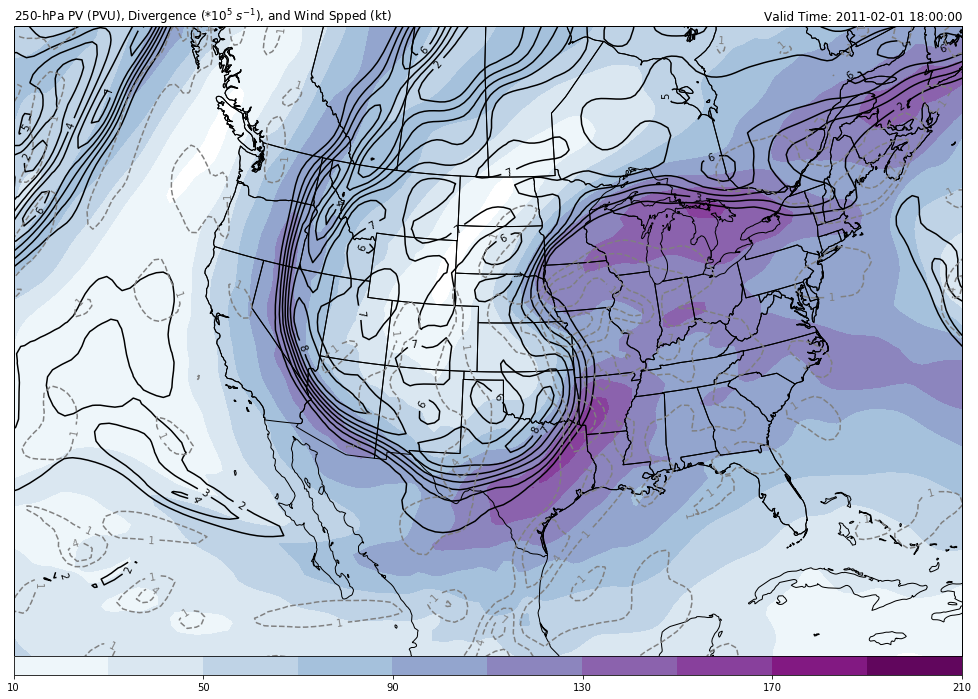

In [11]:
plot_PV(250)

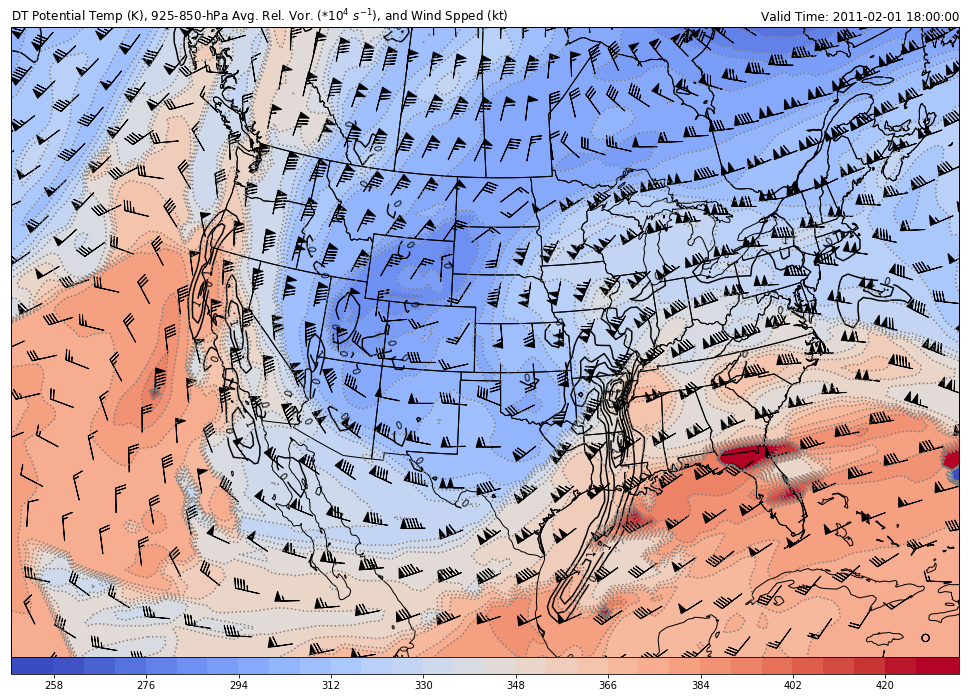

In [14]:
plot_DT()